# Ensemble Learning 

In  this repository, first we will find the optimal paramters for a single decision tree to inpatient bike status from repairs on the Rice Bikes Transactions dataset.. Then we will construct a random forrest from scratch using multiple of these decision trees.

## 0. Imports and Data 

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit

In [25]:
df = pd.read_csv("../../data/rb_tx_data.csv")
df = df.set_index("TransactionID")

df = df.replace(np.nan,0)

df = df.loc[(df['TotalCost']>0) & 
            (df['RepairCost']>0) &
            (df['TurnaroundTime']>0) &
            (df['TurnaroundTime']<38) # corresponds to two weeks
]

X = df.loc[:, df.columns[14:]].values
y = np.where(df['DayCreated']== df['DayCompleted'], 0, 1)


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state = 42)


## 1. Parameter Optimization (Single Tree)

In [26]:
param_grid = {
    'max_depth': list(range(1,40)),
    'max_leaf_nodes': list(range(2,20)),
    'min_samples_split': [2,3,4]
}

grid_search_cv = GridSearchCV(
    DecisionTreeClassifier(criterion = 'entropy'),
    param_grid = param_grid,
    scoring = "accuracy",
    cv = 10,
    n_jobs = -1
).fit(X_train, y_train)

In [27]:
grid_search_cv.best_score_ # best accuracy score on the training set

0.721767637031209

In [28]:
decision_tree = grid_search_cv.best_estimator_
decision_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 11,
 'max_features': None,
 'max_leaf_nodes': 19,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [29]:
def confusion_matrix(y_test, y_pred):
    # The confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

    # Convert confusion matrix into dataframe
    matrix_df = pd.DataFrame(confusion_matrix)


    plt.figure(figsize=(10, 8))
    ax = plt.axes()
    sns.set(font_scale=1.3)

    sns.heatmap(matrix_df,
                annot = True, 
                fmt = "g",
                ax = ax, 
                cmap = "magma", 
                cbar = False)

    ax.set_title("Confusion Matrix - Decision Tree")
    ax.set_xlabel("Predicted Label", fontsize=15)
    ax.set_xticklabels(["Outpatient", "Inpatient"])
    ax.set_ylabel("True Label", fontsize=15)
    ax.set_yticklabels(["Outpatient", "Inpatient"], rotation=0)
    plt.show()


In [30]:
# predicted values on the testing data
y_pred_tree = decision_tree.predict(X_test)

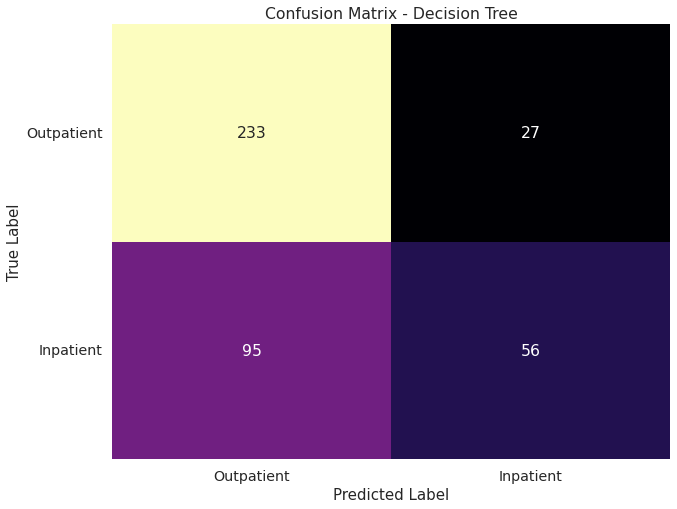

In [31]:
confusion_matrix(y_test, y_pred_tree)

In [32]:
#Checking performance our model with classification report.
print(metrics.classification_report(y_test, y_pred_tree))

metrics.accuracy_score(y_test, y_pred_tree)

              precision    recall  f1-score   support

           0       0.71      0.90      0.79       260
           1       0.67      0.37      0.48       151

    accuracy                           0.70       411
   macro avg       0.69      0.63      0.64       411
weighted avg       0.70      0.70      0.68       411



0.7031630170316302

## 2. Build Random Forrest

In [41]:

n_trees = 1000
n_instances = 500

X_train_subsets = []


rs = ShuffleSplit(n_splits= n_trees, test_size= len(X_train) - n_instances)
for subset_train_index, _ in rs.split(X_train):
    X_subset_train = X_train[subset_train_index]
    y_subset_train = y_train[subset_train_index]
    X_train_subsets.append((X_subset_train, y_subset_train))



In [42]:
# train one decision tree for each subset

trees =[]
accuracies = []

for (X_subset_train, y_subset_train) in X_train_subsets:
    clf = clone(grid_search_cv.best_estimator_)
    clf.fit(X_subset_train, y_subset_train)
    trees.append(clf)
    y_pred = clf.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

sum(accuracies)/n_trees

0.695642335766423

In [43]:
from scipy.stats import mode

# a matrix having dimension n_trees * len(X_test)  
# each row is the prediction of one tree on every element of the test set
tree_preds = np.stack([t.predict(X_test) for t in trees])

y_pred_forrest = mode(tree_preds, axis=0).mode.reshape(-1,1)

metrics.accuracy_score(y_test, y_pred_forrest)


0.7128953771289538

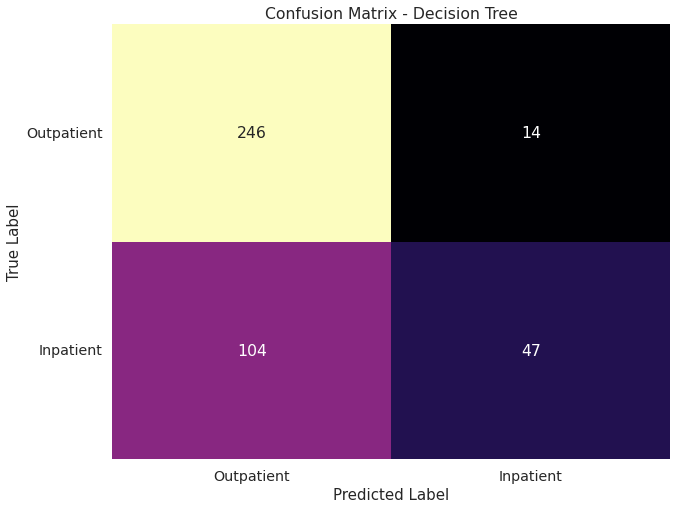

In [44]:
confusion_matrix(y_test, y_pred_forrest)

In [45]:
#Checking performance our model with classification report.
print(metrics.classification_report(y_test, y_pred_forrest))

metrics.accuracy_score(y_test, y_pred_forrest)

              precision    recall  f1-score   support

           0       0.70      0.95      0.81       260
           1       0.77      0.31      0.44       151

    accuracy                           0.71       411
   macro avg       0.74      0.63      0.62       411
weighted avg       0.73      0.71      0.67       411



0.7128953771289538

While the single decision tree was only able to obtain a test set accuracy of 70%, the random forest was able to obtain a test set accuracy of 71%!